In [173]:
using PyPlot

### library functions

In [174]:
function rk2(func, x0, t0, tf, dt)
    n = convert(Int64, ceil((tf - t0)/dt))
    X = Array(Float64,(length(x0), n))
    T = linspace(t0, tf, n)
    X[:,1] = x0
    for i = 2:n
        k1 = func(X[:,i-1], T[i-1])
        k2 = func(X[:,i-1] + 0.5*dt*k1, T[i-1] + 0.5*dt)
        X[:,i] = X[:,i-1] + dt*k2
    end
    return T, X
end

rk2 (generic function with 1 method)

In [196]:
function rk2_test(func_with_derivs, x0, t0, tf, dt)
    n = convert(Int64, ceil((tf - t0)/dt))
    X = Array(Float64,(length(x0), n))
    T = linspace(t0, tf, n)
    X[:,1] = x0
    for i = 2:n
        k1, _ = func(X[:,i-1], T[i-1])
        k2, _ = func(X[:,i-1] + 0.5*dt*k1, T[i-1] + 0.5*dt)
        X[:,i] = X[:,i-1] + dt*k2
    end
    return T, X
end

rk2_test (generic function with 1 method)

In [191]:
function rk2_with_derivs(func_with_jac, x0, t0, tf, dt)
    n = convert(Int64, ceil((tf - t0)/dt))
    X = Array(Float64,(length(x0), n))
    T = linspace(t0, tf, n)
    deriv = eye(length(x0))
    X[:,1] = x0
    for i = 2:n
        k1, j1 = func(X[:,i-1], T[i-1])
        k2, j2 = func(X[:,i-1] + 0.5*dt*k1, T[i-1] + 0.5*dt)
        X[:,i] = X[:,i-1] + dt*k2
        deriv += dt*j2*(eye(length(x0)) + 0.5*dt*j1)*deriv
    end
    return T, X, deriv
end

rk2_with_derivs (generic function with 1 method)

In [176]:
function newton(function_and_derivative, initial_guess, tol)
    x = initial_guess
    f_of_x, df_of_x = function_and_derivative(initial_guess)
    while norm(f_of_x) > tol
        x -= df_of_x\f_of_x
        f_of_x, df_of_x = function_and_derivative(x)
    end
    return x
end

newton (generic function with 1 method)

### problem specific

In [177]:
m = 5 # kg
minv = 1.0/m
g = 9.8 # m/sec^2
thrust_to_weight_ratio = 3.0 
f = thrust_to_weight_ratio * m * g; #newtons
initial_angle = 0.49*pi;

In [178]:
free_time = 0.01

0.01

In [179]:
x_init = 0.5*f*free_time^2*cos(initial_angle)
y_init = 0.5*(f-g)*free_time^2*sin(initial_angle)
p_x_init = f*free_time*cos(initial_angle)
p_y_init = f*free_time*sin(initial_angle)

1.4692746437376254

In [180]:
function func(state, t)
    x,y = state[1], state[2]
    p_x, p_y = state[3], state[4]
    psi_x, psi_y = state[5], state[6]
    psi_p_x, psi_p_y = state[7], state[8]
    
    # no propellant consumption yet
    
    tan_phi = (p_y - m*psi_p_y)/(p_x - m*psi_p_x)
    denom = sqrt(1 + tan_phi^2)
    cos_phi = 1/denom
    sin_phi = tan_phi/denom
    
    derv = [p_x/m, p_y/m,
            f*cos_phi, f*sin_phi - m*g,
            0.0, 0.0,
            f/m*cos_phi - psi_x/m, f/m*sin_phi - psi_y/m]
    return derv
end

func (generic function with 1 method)

In [210]:
function func_with_jac(state, t)
    x,y = state[1], state[2]
    p_x, p_y = state[3], state[4]
    psi_x, psi_y = state[5], state[6]
    psi_p_x, psi_p_y = state[7], state[8]
    
    # no propellant consumption yet
    
    tan_num = p_y - m*psi_p_y
    tan_denom = p_x - m*psi_p_x
    tan_phi = (p_y - m*psi_p_y)/(p_x - m*psi_p_x)
    denom = sqrt(1 + tan_phi^2)
    cos_phi = 1/denom
    sin_phi = tan_phi/denom
    
    arctan_d = 1.0/(1.0 + arctan(tan_phi)^2)
    
    d_denom = (tan_phi^2 + 1)*sqrt(tan_phi^2 + 1)
    d_cos_arctan = -tan_phi/d_denom
    d_sin_arctan = 1.0/d_denom
    
    #derv = [p_x/m, p_y/m,
    #        f*cos_phi, f*sin_phi - m*g,
    #        0.0, 0.0,
    #        f/m*cos_phi - psi_x/m, f/m*sin_phi - psi_y/m]
    derv = func(state, t)
    
    jac = [ 
        0 0 minv 0 0 0 0 0;
        0 0 0 minv 0 0 0 0;
        0 0 -f*d_cos_arctan*tan_phi/tan_denom f*d_sin_arctan/tan_denom 0 0 
            f*d_cos_arctan*tan_phi*m/tan_denom -f*d_cos_arctan*m/tan_denom;
        0 0 -f*d_sin_arctan*tan_phi/tan_denom f*d_sin_arctan/tan_denom 0 0 
            f*d_sin_arctan*tan_phi*m/tan_denom -f*d_sin_arctan*m/tan_denom;
        0 0 0 0 0 0 0 0;
        0 0 0 0 0 0 0 0;
        0 0 -minv*f*d_cos_arctan*tan_phi/tan_denom minv*f*d_sin_arctan/tan_denom -minv 0 
            f*minv*d_cos_arctan*tan_phi*m/tan_denom -minv*f*d_cos_arctan*m/tan_denom;
        0 0 -f*minv*d_sin_arctan*tan_phi/tan_denom minv*f*d_sin_arctan/tan_denom 0 -minv
            f*minv*d_sin_arctan*tan_phi*m/tan_denom -f*minv*d_sin_arctan*m/tan_denom;
    ]
    return func(state, t), jac
end        

func_with_jac (generic function with 1 method)

In [208]:
function evaluate_choices(first_costate_inits_and_time)
    t_f = first_costate_inits_and_time[4]
    
    psi_x_init = first_costate_inits_and_time[1]
    psi_y_init = first_costate_inits_and_time[2]
    psi_p_x_init = first_costate_inits_and_time[3]
    psi_p_y_init = p_y_init/m - tan(initial_angle)*(p_x_init/m - psi_p_x_init)
    initial_full_state = [x_init, y_init,
                          p_x_init, p_y_init,
        psi_x_init, psi_y_init,
        psi_p_x_init, psi_p_y_init]
    println(initial_full_state)
    T, X, derivs = rk2_with_derivs(func_with_jac, initial_full_state, free_time, t_f, 0.01)
    println(derivs)
    return X[2:4, end], [ derivs[2:4,5:7] func(X[:,end],T[end])[2:4]], T, X
end

evaluate_choices (generic function with 1 method)

[0.00023086907922424373,0.006856615004108919,0.04617381584484874,1.4692746437376254,-18.0,5.0,4.0,127.28206381509541]
[0.8777788000459953,0.8844045459708801,0.9237217468116202,2.346822574704401,-17.122452069033194,5.877547930966775,4.877547930966775,128.15961174606187]


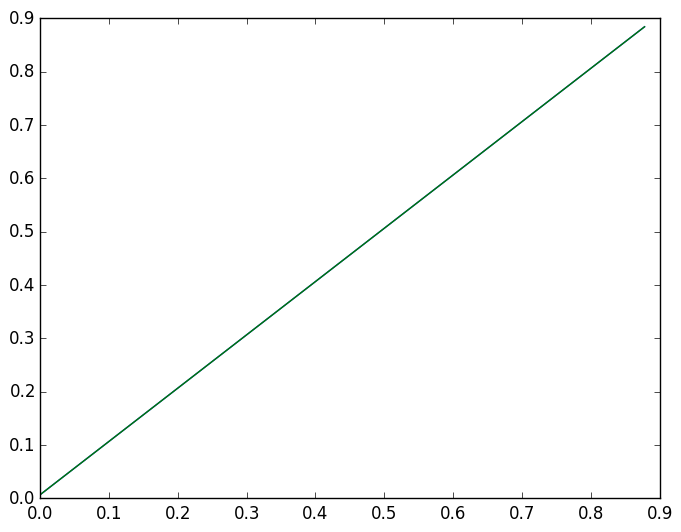

In [211]:
z_init = [x_init, y_init, p_x_init, p_y_init, 
    -18.0, 5.0, 4.0,  p_y_init/m - tan(initial_angle)*(p_x_init/m - 4.0)];
println(z_init)
Td, Xd, _ = rk2_with_derivs(func_with_jac, z_init, free_time, 15.0, 0.01)
T, X = rk2_test(func_with_jac, z_init, free_time, 15.0, 0.01)
plot(X[1,:][:], X[2,:][:])
plot(Xd[1,:][:], Xd[2,:][:])
println(X[:,end])

In [185]:
tan_phi = (X[4,:][:] - m*X[8,:][:])./(X[3,:][:] - m*X[7,:][:]);
denom = sqrt(1.0 + tan_phi.^2);
sin_phi = tan_phi./denom;
cos_phi = 1.0./denom;

In [186]:
dEdt = f.*minv.*(X[3,:][:].*cos_phi + X[4,:][:].*sin_phi);

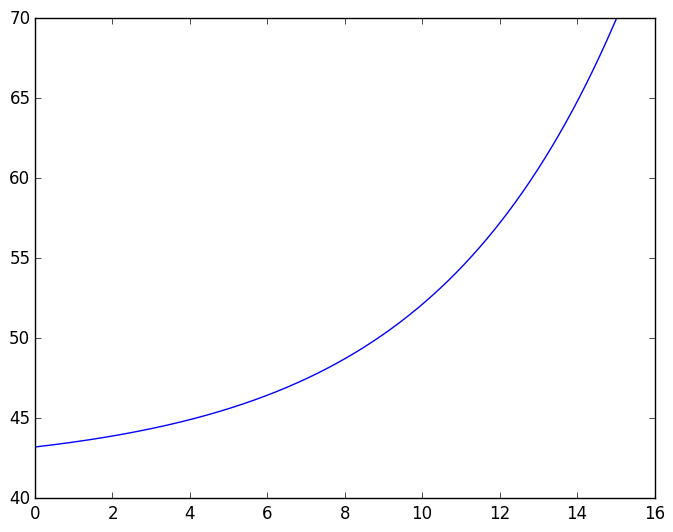

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fab6b58da50>

In [187]:
plot(T, dEdt)

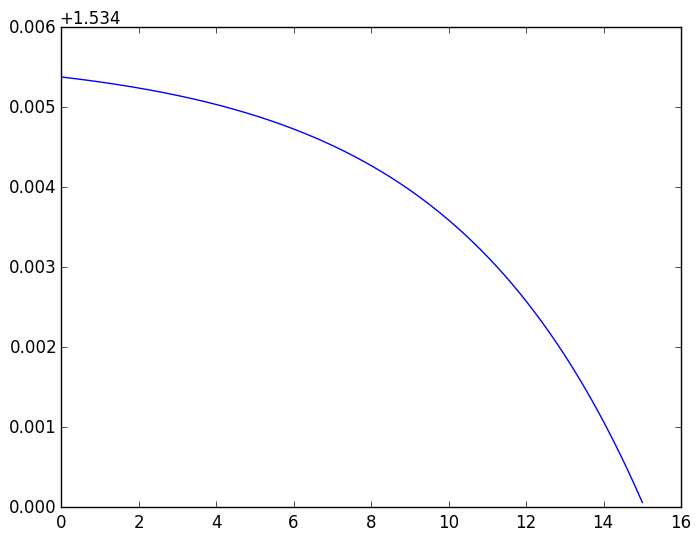

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fab6b4c9950>

In [188]:
plot(T, atan(tan_phi))